---
🔠 Natural Language Processing (CS60075) Autumn 2024, IIT Kharagpur

📃 Assignment 1: [Enhancing Emotion Recognition Using POS Tagging](https://sites.google.com/view/nlp-cs-iit-kgp/assignments)

👦🏻 Author: [Prasanna Paithankar (21CS30065)](https://cse.iitkgp.ac.in/~prasannabp/)

📰 [Assignment Report](./NLP_Assignment_1_21CS30065.pdf)

---

#### 1. 🏷️ POS Tagger Implementation

##### 📚 Import Libraries and Resources 

In [1]:
import nltk
from nltk.corpus import treebank
from nltk.tokenize import word_tokenize

In [2]:
nltk.download('treebank')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\paith\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\paith\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\paith\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
tagged_sentences = treebank.tagged_sents()
print('Total tagged sentences:', len(tagged_sentences))

correct = 0
total = 0
for sentence in tagged_sentences:
    words, tags = zip(*sentence)
    predicted_tags = [tag for word, tag in nltk.pos_tag(words)]
    correct += sum(1 for i in range(len(tags)) if tags[i] == predicted_tags[i])
    total += len(tags) 

# Add start and end tags to the sentences
tagged_sentences_temp = [None] * len(tagged_sentences)
for i in range(len(tagged_sentences)):
    tagged_sentences_temp[i] = [('<s>', '<s>')] + tagged_sentences[i] + [('</s>', '</s>')]

tagged_sentences = tagged_sentences_temp

eps = 1e-5  # Smoothing parameter

Total tagged sentences: 3914


##### 📊 Compute Transition and Emission Probabilities

In [4]:
# Tag frequency
tag_counts = {}
for sentence in tagged_sentences:
    for word, tag in sentence:
        if tag not in tag_counts:
            tag_counts[tag] = 0
        tag_counts[tag] += 1

tagset = tag_counts.keys()

# Bigram tag frequency
tag_bigram_counts = {}
for sentence in tagged_sentences:
    for i in range(len(sentence) - 1):
        tag1 = sentence[i][1]
        tag2 = sentence[i + 1][1]
        if tag1 not in tag_bigram_counts:
            tag_bigram_counts[tag1] = {}
        if tag2 not in tag_bigram_counts[tag1]:
            tag_bigram_counts[tag1][tag2] = 0
        tag_bigram_counts[tag1][tag2] += 1

# P_smoothened(tag2|tag1) = (count(tag1, tag2) + eps) / (count(tag1) + eps * N)
transition_probabilities = {}
for tag1 in tagset:
    transition_probabilities[tag1] = {}
    for tag2 in tagset:
        if tag1 in tag_bigram_counts and tag2 in tag_bigram_counts[tag1]:
            transition_probabilities[tag1][tag2] = (tag_bigram_counts[tag1][tag2] + eps) / (tag_counts[tag1] + eps * len(tag_counts))
        else:
            transition_probabilities[tag1][tag2] = eps / (tag_counts[tag1] + eps * len(tag_counts))

# Word-tag frequency
word_tag_counts = {}
for sentence in tagged_sentences:
    for word, tag in sentence:
        if word not in word_tag_counts:
            word_tag_counts[word] = {}
        if tag not in word_tag_counts[word]:
            word_tag_counts[word][tag] = 0
        word_tag_counts[word][tag] += 1

# P_smoothened(word|tag) = (count(tag, word) + eps) / (count(tag) + eps * N)
emission_probabilities = {}
for word in word_tag_counts:
    emission_probabilities[word] = {}
    for tag in word_tag_counts[word]:
        emission_probabilities[word][tag] = (word_tag_counts[word][tag] + eps) / (tag_counts[tag] + eps * len(tag_counts))

##### 🧮 Viterbi Algorithm for POS tagging

Input: sentence = [word1, word2, ..., wordN]

Output: tags = [tag1, tag2, ..., tagN]


In [5]:
def viterbi(sentence):
    '''
    Description: This function implements the Viterbi algorithm for POS tagging.

    Arguments:
        sentence: A list of words in the sentence.

    Returns:
        tags: A list of POS tags for the words in the sentence.
    '''

    n = len(sentence)
    dp = [{} for _ in range(n)]
    backpointers = [{} for _ in range(n)]
    
    for tag in tagset:
        dp[0][tag] = transition_probabilities['<s>'][tag] * emission_probabilities.get(sentence[0], {}).get(tag, eps)
        backpointers[0][tag] = '<s>'
    
    # Dynamic programming step
    for i in range(1, n):
        for tag in tagset:
            dp[i][tag], backpointers[i][tag] = max(
                (dp[i - 1][prev_tag] * transition_probabilities[prev_tag][tag] * emission_probabilities.get(sentence[i], {}).get(tag, eps), prev_tag)
                for prev_tag in tagset
            )
    
    # Find the best tag for the last word
    best_prob, best_tag = max((dp[n - 1][tag], tag) for tag in tagset)
    
    # Backtrack to find the best tag sequence
    tags = [best_tag]
    for i in range(n - 1, 0, -1):
        best_tag = backpointers[i][best_tag]
        tags.append(best_tag)
    
    tags.reverse()
    return tags

##### ⚖️ Evaluation of POS Tagger

In [6]:
print('Accuracy of nltk pos tagger:', correct / total)

correct = 0
total = 0
for sentence in treebank.tagged_sents():
    words, tags = zip(*sentence)
    predicted_tags = viterbi(words)
    correct += sum(1 for i in range(len(tags)) if tags[i] == predicted_tags[i])
    total += len(tags)

print('Accuracy of Viterbi algorithm:', correct / total)

Accuracy of nltk pos tagger: 0.8929834319996821
Accuracy of Viterbi algorithm: 0.9716218363860304


In [7]:
print('Sample sentences:\n')
print('Output format: [(Word, Actual tag, Predicted tag), ... ]\n')
for sentence in treebank.tagged_sents()[:5]:
    words, tags = zip(*sentence)
    predicted_tags = viterbi(words)
    print(list(zip(words, tags, predicted_tags)))

print('\n')

Sample sentences:

Output format: [(Word, Actual tag, Predicted tag), ... ]

[('Pierre', 'NNP', 'NNP'), ('Vinken', 'NNP', 'NNP'), (',', ',', ','), ('61', 'CD', 'CD'), ('years', 'NNS', 'NNS'), ('old', 'JJ', 'JJ'), (',', ',', ','), ('will', 'MD', 'MD'), ('join', 'VB', 'VB'), ('the', 'DT', 'DT'), ('board', 'NN', 'NN'), ('as', 'IN', 'IN'), ('a', 'DT', 'DT'), ('nonexecutive', 'JJ', 'JJ'), ('director', 'NN', 'NN'), ('Nov.', 'NNP', 'NNP'), ('29', 'CD', 'CD'), ('.', '.', '.')]
[('Mr.', 'NNP', 'NNP'), ('Vinken', 'NNP', 'NNP'), ('is', 'VBZ', 'VBZ'), ('chairman', 'NN', 'NN'), ('of', 'IN', 'IN'), ('Elsevier', 'NNP', 'NNP'), ('N.V.', 'NNP', 'NNP'), (',', ',', ','), ('the', 'DT', 'DT'), ('Dutch', 'NNP', 'JJ'), ('publishing', 'VBG', 'NN'), ('group', 'NN', 'NN'), ('.', '.', '.')]
[('Rudolph', 'NNP', 'NNP'), ('Agnew', 'NNP', 'NNP'), (',', ',', ','), ('55', 'CD', 'CD'), ('years', 'NNS', 'NNS'), ('old', 'JJ', 'JJ'), ('and', 'CC', 'CC'), ('former', 'JJ', 'JJ'), ('chairman', 'NN', 'NN'), ('of', 'IN', 'IN')

***

#### 2. 😎 Vanilla Emotion Recognizer

##### 📚 Import Libraries and Resources

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

d:\Codes\Natural-Language-Processing-Aut-24\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
ds = load_dataset("dair-ai/emotion", "split")

##### 🧪 Preprocessing

In [10]:
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = text.lower()
    text = ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(text)])
    return text

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\paith\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


##### 🏹 TF-IDF Vectorization

In [11]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(preprocess(text) for text in ds['train']['text'])
X_val = vectorizer.transform(preprocess(text) for text in ds['validation']['text'])
X_test = vectorizer.transform(preprocess(text) for text in ds['test']['text'])

##### 🧠 Model Training

##### 🔨 Naive Bayes

In [12]:
clf = MultinomialNB()
clf.fit(X_train, ds['train']['label'])

MultinomialNB()

In [13]:
# Predict on the validation data.
val_preds = clf.predict(X_val)
print('Validation accuracy:', accuracy_score(
    ds['validation']['label'], val_preds))

# Predict on the test data.
test_preds = clf.predict(X_test)
print('Test accuracy:', accuracy_score(ds['test']['label'], test_preds))

Validation accuracy: 0.648
Test accuracy: 0.6585


In [14]:
print(classification_report(ds['test']['label'], test_preds))

              precision    recall  f1-score   support

           0       0.68      0.92      0.78       581
           1       0.62      0.99      0.76       695
           2       1.00      0.03      0.05       159
           3       0.94      0.19      0.31       275
           4       1.00      0.19      0.32       224
           5       0.00      0.00      0.00        66

    accuracy                           0.66      2000
   macro avg       0.71      0.38      0.37      2000
weighted avg       0.73      0.66      0.57      2000



d:\Codes\Natural-Language-Processing-Aut-24\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Codes\Natural-Language-Processing-Aut-24\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Codes\Natural-Language-Processing-Aut-24\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

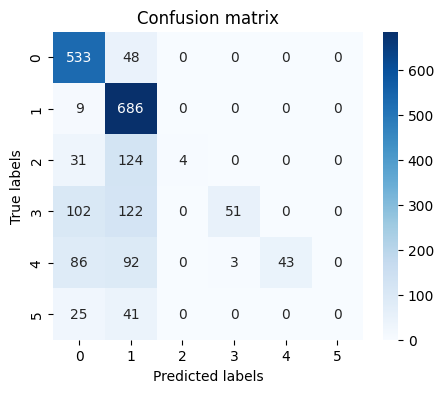

In [15]:
cm = confusion_matrix(ds['test']['label'], test_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix')
plt.show()

##### 🛠️ Support Vector Machine 

In [16]:
clf = SVC()
clf.fit(X_train, ds['train']['label'])

SVC()

In [17]:
val_preds = clf.predict(X_val)
print('Validation accuracy:', accuracy_score(
    ds['validation']['label'], val_preds))

# Predict on the test data.
test_preds = clf.predict(X_test)
print('Test accuracy:', accuracy_score(ds['test']['label'], test_preds))

Validation accuracy: 0.862
Test accuracy: 0.856


In [18]:
print(classification_report(ds['test']['label'], test_preds))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       581
           1       0.82      0.96      0.88       695
           2       0.87      0.54      0.67       159
           3       0.90      0.79      0.84       275
           4       0.86      0.78      0.82       224
           5       0.85      0.44      0.58        66

    accuracy                           0.86      2000
   macro avg       0.86      0.74      0.78      2000
weighted avg       0.86      0.86      0.85      2000



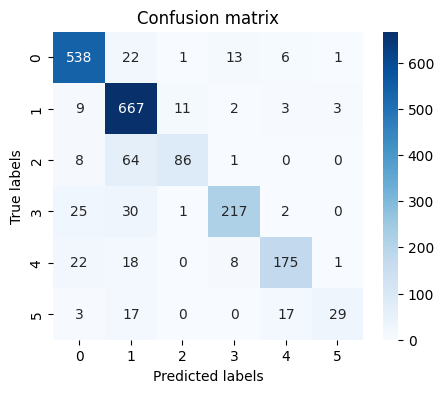

In [19]:
cm = confusion_matrix(ds['test']['label'], test_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix')
plt.show()

***

#### 3. 🧐 Improved Emotion Recognizer

##### 🛣️ Pipeline
Input: sentence 

Output: emotion class

1. Compute POS Tags for a given sentence
2. Remove the words with POS tags other than Nouns, Verbs, Adjectives, and Adverbs
3. Compute TF-IDF Vectorization
4. Train the model using Naive Bayes and SVM
5. Evaluate the model

In [20]:
def remove_pos_tags(text, pos_tags, POS_tagger):
    '''
    Description: This function removes the specified POS tags from the text.

    Arguments:
        text: A string representing the text.
        pos_tags: A list of POS tags to be removed.
        POS_tagger: A POS tagger function.

    Returns:
        new_text: A string representing the text with the specified POS tags removed.
    '''
    
    words = word_tokenize(text)
    pos = POS_tagger(words)
    new_words = [word for i, word in enumerate(words) if pos[i][1] not in pos_tags]
    return ' '.join(new_words)

tagger = nltk.pos_tag
compl_tags = ['CC', 'CD', 'DT', 'EX', 'IN', 'LS', 'MD', 'PRP', 'PRP$', 'SYM', 'TO', '$', '#', '.', ',', ':', '(', ')', '"', "'"]

train_no_pos = [remove_pos_tags(text, compl_tags, tagger) for text in ds['train']['text']]
val_no_pos = [remove_pos_tags(text, compl_tags, tagger) for text in ds['validation']['text']]
test_no_pos = [remove_pos_tags(text, compl_tags, tagger) for text in ds['test']['text']]

##### 🏹 TF-IDF Vectorization

In [21]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(preprocess(text) for text in train_no_pos)
X_val = vectorizer.transform(preprocess(text) for text in val_no_pos)
X_test = vectorizer.transform(preprocess(text) for text in test_no_pos)

##### 🧠 Model Training

##### 🔨 Naive Bayes

In [22]:
clf = MultinomialNB()
clf.fit(X_train, ds['train']['label'])

MultinomialNB()

In [23]:
# Predict on the validation data.
val_preds = clf.predict(X_val)
print('Validation accuracy:', accuracy_score(
    ds['validation']['label'], val_preds))

# Predict on the test data.
test_preds = clf.predict(X_test)
print('Test accuracy:', accuracy_score(ds['test']['label'], test_preds))

Validation accuracy: 0.666
Test accuracy: 0.679


In [24]:
print(classification_report(ds['test']['label'], test_preds))

              precision    recall  f1-score   support

           0       0.68      0.93      0.79       581
           1       0.64      0.98      0.78       695
           2       1.00      0.04      0.08       159
           3       0.94      0.27      0.41       275
           4       0.92      0.25      0.39       224
           5       0.00      0.00      0.00        66

    accuracy                           0.68      2000
   macro avg       0.70      0.41      0.41      2000
weighted avg       0.73      0.68      0.61      2000



d:\Codes\Natural-Language-Processing-Aut-24\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Codes\Natural-Language-Processing-Aut-24\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Codes\Natural-Language-Processing-Aut-24\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

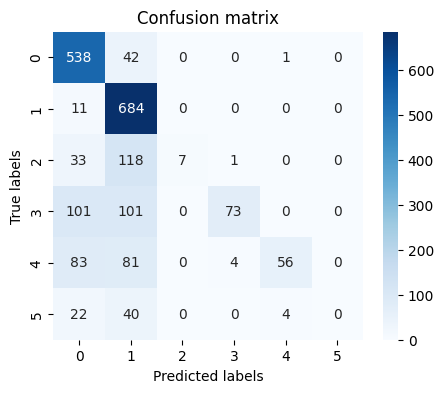

In [25]:
cm = confusion_matrix(ds['test']['label'], test_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix')
plt.show()

##### 🛠️ Support Vector Machine

In [26]:
clf = SVC()
clf.fit(X_train, ds['train']['label'])

SVC()

In [27]:
val_preds = clf.predict(X_val)
print('Validation accuracy:', accuracy_score(
    ds['validation']['label'], val_preds))

# Predict on the test data.
test_preds = clf.predict(X_test)
print('Test accuracy:', accuracy_score(ds['test']['label'], test_preds))

Validation accuracy: 0.862
Test accuracy: 0.8585


In [28]:
print(classification_report(ds['test']['label'], test_preds))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       581
           1       0.81      0.96      0.88       695
           2       0.87      0.53      0.66       159
           3       0.90      0.79      0.84       275
           4       0.87      0.79      0.82       224
           5       0.85      0.50      0.63        66

    accuracy                           0.86      2000
   macro avg       0.87      0.75      0.79      2000
weighted avg       0.86      0.86      0.85      2000



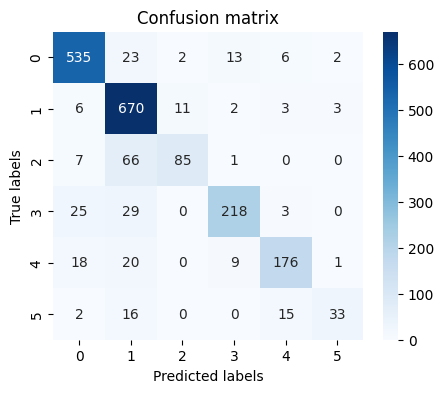

In [29]:
cm = confusion_matrix(ds['test']['label'], test_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix')
plt.show()

***
Prasanna Paithankar (21CS30065)